# Intro
In this project I take a look at my spending on coffee. It stems from my habit of drinking it in coffee shops, which I did a lot in the last couple of years. This is an opportunity to explore it.

### Data
As the data is taken from a statement of account, it is quite messy, so it involves a lot of data cleaning and tidying. Here's a snippet from the original Excel table with the transaction history:<br>
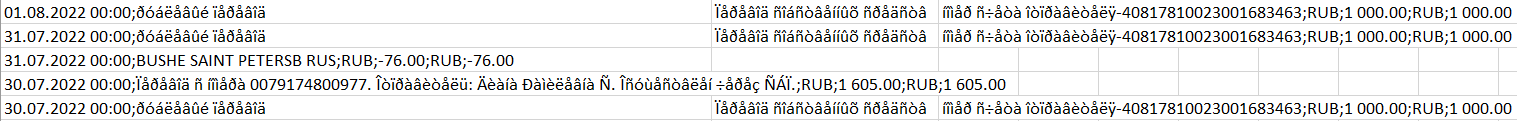<br>
Here, Excel has problems with reading Cyrillic text. But the organization names of all coffee shops are in English.

### Goals and Methods


With the help of visualization and, if needed, statistical tests I'd like to solve the following problems:
1. Summarize the coffee consumption by month.
2. Did coffee consumption increase or decreased over time?
3. Did I visit the coffee shops more often in winter?
4. What was the average check for coffee and how many visits I made – by month?
5. Break down the coffee consumption by days of the week and find whether I spent the most and visit more often on weekends.
6. What is the percentage of coffee in total expenses?

### Expectations

It seems like most of the answers can be found without testing a hypothesis (maybe question 4 would require the Wilcoxon rank sum test, but we'll see). <br>
I see the main challenge in the cleaning process. 

# Explore Data

Import libraries and load the data sets

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
acc = pd.read_csv('account_statement.csv', delimiter=';', header=None, encoding='latin-1')

In [3]:
acc.head()

,0,1,2,3,4,5
0,Äàòà òðàíçàêöèè,Îïèñàíèå,Âàëþòà îïåðàöèè,Ñóììà â âàëþòå îïåðàöèè,Âàëþòà ñ÷åòà,Ñóììà â âàëþòå ñ÷åòà
1,01.08.2022 00:00,"ðóáëåâûé ïåðåâîä,Ïåðåâîä ñîáñòâåííûõ ñðåäñòâ,í...",RUB,1 000.00,RUB,1 000.00
2,31.07.2022 00:00,"ðóáëåâûé ïåðåâîä,Ïåðåâîä ñîáñòâåííûõ ñðåäñòâ,í...",RUB,1 000.00,RUB,1 000.00
3,31.07.2022 00:00,BUSHE SAINT PETERSB RUS,RUB,-76.00,RUB,-76.00
4,30.07.2022 00:00,Ïåðåâîä ñ íîìåðà 0079174800977. Îòïðàâèòåëü: Ä...,RUB,1 605.00,RUB,1 605.00


In [4]:
acc.shape

(4332, 6)

In [5]:
acc.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
dtype: object

This dataset contains 4332 rows and six columns, two of which are duplicates. The four remaining columns of the datetime contain:
- Date (without time) of the transaction;
- Names of the stores and shops where the transaction took place;
- Currency;
- Sum (float, but just as every other variable, is seen as an object).

Some values in the second column are just text gibberish, so it should probably be dropped as they don't mean anything.

# Process Data

### Acount

#### Dropping and renaming

In [10]:
# Drop the first row, which doesn't make sense
acc = acc.drop(index=0)

In [11]:
# Change the column names
cols = ['date', 'place', 'currency', 'spent', 'currency2', 'spent2']
acc.columns = cols

In [12]:
# Drop duplicating columns
acc = acc.drop(columns=['currency2', 'spent2'])

#### Delete rows with unreadable signs

In [13]:
# Find rows in the place column which does not contain latin letters
latin_letters = acc.place.str.contains(r'([A-Za-z])')
# Drop them
acc = acc.loc[latin_letters].reset_index(drop=True)

C:\Users\jrank\AppData\Local\Temp\ipykernel_5552\199650943.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  latin_letters = acc.place.str.contains(r'([A-Za-z])')


# Analyze Data

#### Creating DataFrames based on different coffee shops
It's time to analyze coffee consumption. First, create a DataFrame with all possible purchases at the coffeeshops (list of places is imported from another file).

In [40]:
# First, fix the spent column in the acc DataFrame
acc['spent'] = acc['spent'].apply(lambda x: float(x.replace(' ', '')))

In [41]:
# Function which adds all the rows with mathcing string patterns to a Coffee DataFrame
def extract_coffee_place(places):
    coffee = pd.DataFrame(columns=acc.columns)
    for place in places:
        this_spot = acc.loc[acc['place'].str.contains(place)]
        coffee = pd.concat([coffee, this_spot])
    return coffee

In [42]:
# Import list of coffee shops
from coffee_spots import coffee_spots
spots = coffee_spots()

# Create a DataFrame with all purchases in coffee shops
coffee = extract_coffee_place(spots).drop(columns=['place', 'currency']).reset_index(drop=True)
del coffee_spots, spots, acc['place']

In [43]:
coffee.head()

,date,spent
0,25.07.2022 00:00,-510.0
1,01.06.2022 00:00,-990.0
2,18.02.2022 00:00,-520.0
3,18.02.2022 00:00,-900.0
4,16.02.2022 00:00,-300.0


#### Change Data Types

In [44]:
# Fix data types
coffee['date'] = pd.to_datetime(coffee['date'], dayfirst=True)

# Change negative values to positive for convinience 
#       Note: I didn't do this with the acc table, because it contains not only expanses, but also incomes
coffee['spent'] = (coffee['spent'] * -1).astype('float')

# Check them
coffee.dtypes

date     datetime64[ns]
spent           float64
dtype: object

In [45]:
# Finally, sort
coffee = coffee.sort_values(by='date').reset_index(drop=True)

In [46]:
# Describe th spent variable
coffee.spent.describe()

count    190.000000
mean     483.305263
std      231.203183
min       90.000000
25%      300.000000
50%      460.000000
75%      690.000000
max      990.000000
Name: spent, dtype: float64

#### Coffee consumption by month

In [47]:
coffee['month_year'] = coffee['date'].dt.to_period('M')
coffee_by_month = coffee.groupby('month_year').spent.agg(['sum', 'mean']).reset_index()
coffee_by_month.head()

,month_year,sum,mean
0,2020-08,1598.0,799.000000
1,2020-09,1490.0,496.666667
2,2020-10,490.0,490.000000
3,2020-11,3690.0,615.000000
4,2020-12,2530.0,632.500000


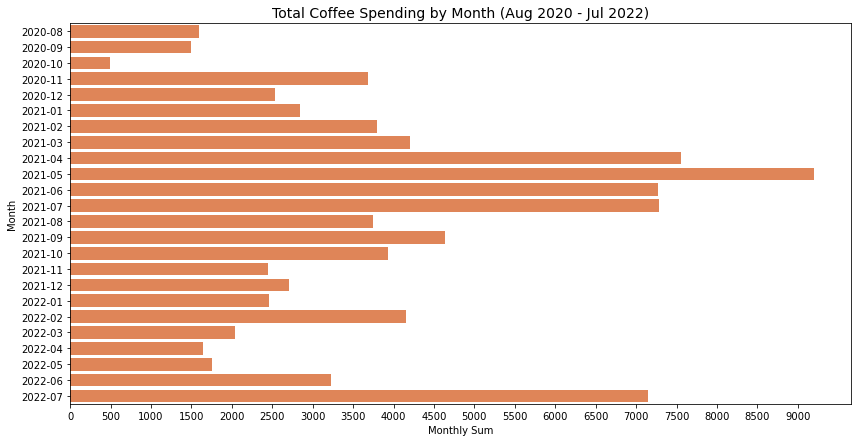

In [48]:
# Total Coffee Spending by Month (bar plot)
plt.figure(figsize=(14, 7))
x = np.arange(0, coffee_by_month['sum'].max(), 500)

sns.barplot(data=coffee_by_month, y='month_year', x='sum', color='#f57e42')
plt.xticks(x)
plt.title('Total Coffee Spending by Month (Aug 2020 - Jul 2022)', fontsize=14)
plt.xlabel('Monthly Sum')
plt.ylabel('Month')
plt.show()

It seems like the spending on coffee has steadily declined from the peak of May 2021, but skyrocketed again in the last two months. <br>

In order to see if the overall spending has decreased or increased add a line with a cumulative average by month (not by check), as if with window functions in SQL.

In [49]:
sum_list = []
running_monthly_avg = []
for ind, row in coffee_by_month.iterrows():
    sum_list.append(row['sum'])
    running_monthly_avg.append(np.mean(sum_list))

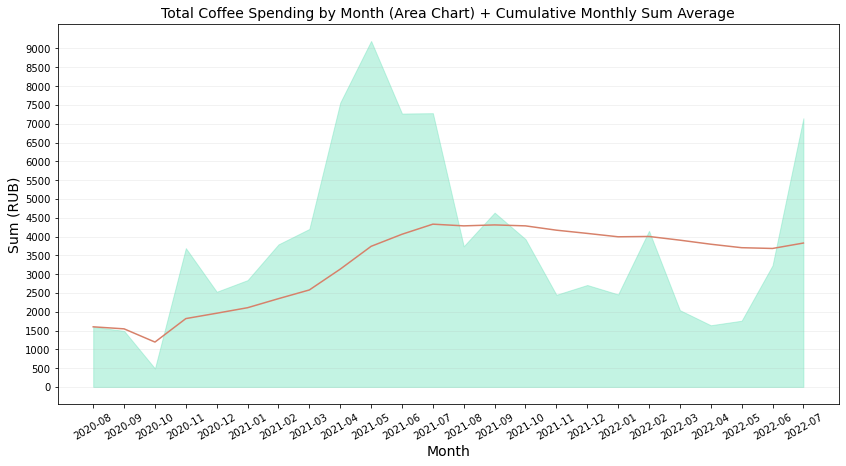

In [50]:
# Total Coffee Spending by Month (Area Chart) + Running Cumulative Monthly Sum
plt.figure(figsize=(14, 7))

ax = plt.subplot()

x = range(len(coffee_by_month['month_year']))
x_label = list(coffee_by_month['month_year'])
y = np.arange(0, coffee_by_month['sum'].max(), 500)

plt.fill_between(x, 0, coffee_by_month['sum'], color="#6be3bb", alpha=0.4)
plt.plot(running_monthly_avg, color='#d7816a')

plt.xticks(rotation=30)
ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yticks(y)
ax.grid(visible=True, alpha=0.2, axis='y')

plt.title("Total Coffee Spending by Month (Area Chart) + Cumulative Monthly Sum Average", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sum (RUB)", fontsize=14)
plt.show()

The spending has, in fact, dropped since May 2021. <br>

Now, take a look at the average check each month and the number of visits.

In [51]:
# First, calculate the number of visits each month
visits = list(coffee.groupby('month_year').spent.count())

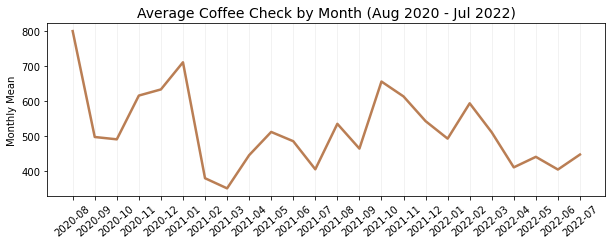

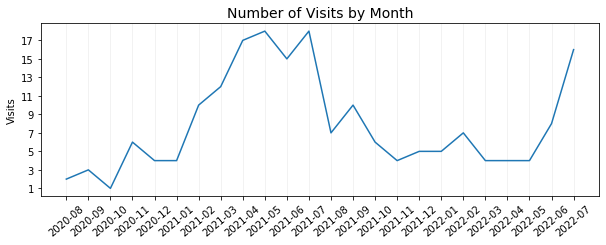

In [52]:
# Average Coffee Spending by Month
plt.figure(figsize=(10, 7))
ax = plt.subplot(2, 1, 1)

plt.plot(coffee_by_month['mean'], color="#ba7e54", linewidth=2.5)

plt.xticks(rotation=40)
ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.grid(visible=True, alpha=0.2, axis='x')

plt.title('Average Coffee Check by Month (Aug 2020 - Jul 2022)', fontsize=14)
plt.ylabel('Monthly Mean')

plt.show()


plt.figure(figsize=(10, 7))
ax = plt.subplot(2, 1, 2)

plt.plot(visits)

plt.xticks(rotation=40)
ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yticks(range(np.min(visits), np.max(visits), 2))
ax.grid(visible=True, alpha=0.2, axis='x')

plt.title('Number of Visits by Month', fontsize=14)
plt.ylabel('Visits')

plt.show()

#### By days of week
The next question is on which day of the week, I tended to drink more coffee.

In [53]:
# Take a look at the group statistics (sum, count and average) by day of week
coffee['day_of_week'] = coffee['date'].dt.day_name()
coffee_week = coffee.groupby('day_of_week')['spent'].agg(['sum', 'count', 'mean']).reset_index()
coffee_week['day_of_week'] = pd.Categorical(coffee_week['day_of_week'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
coffee_week = coffee_week.sort_values(by='day_of_week').reset_index(drop=True)
coffee_week

,day_of_week,sum,count,mean
0,Monday,9678.0,18,537.666667
1,Tuesday,11680.0,23,507.826087
2,Wednesday,13565.0,24,565.208333
3,Thursday,8555.0,20,427.750000
4,Friday,14120.0,30,470.666667
5,Saturday,17950.0,40,448.750000
6,Sunday,16280.0,35,465.142857


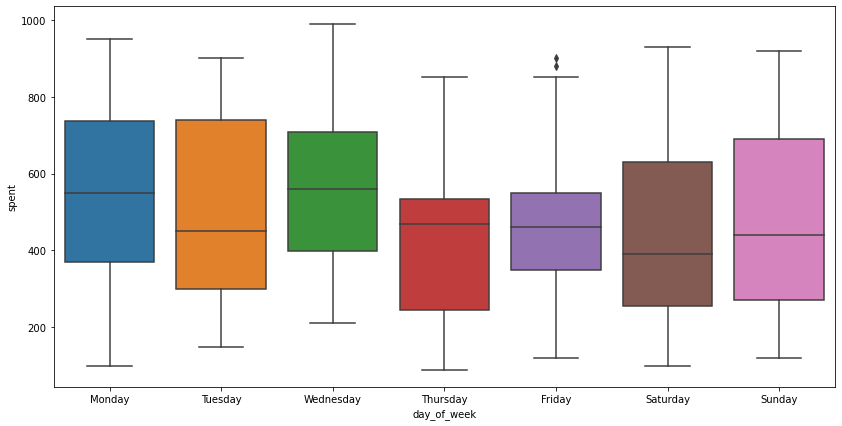

In [54]:
# Here we can see the quintile statistics. By now, it doesn't really answer the question of when I drank coffee the most often
plt.figure(figsize=(14, 7))
sns.boxplot(data=coffee, x='day_of_week', y='spent', showfliers=True, order=coffee_week['day_of_week'])
plt.show()

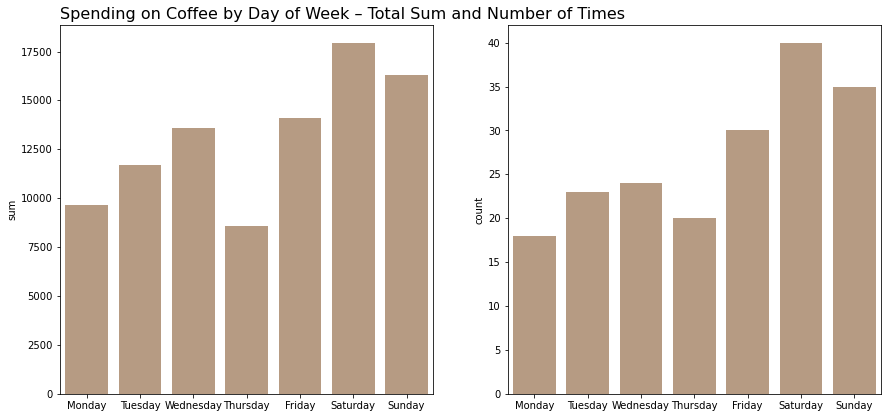

In [55]:
plt.subplot(1, 2, 1)
sns.barplot(data=coffee_week, x='day_of_week', y='sum', color='#be9b7b')
plt.title('Spending on Coffee by Day of Week – Total Sum and Number of Times', loc='left', fontsize=16)
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.barplot(data=coffee_week, x='day_of_week', y='count', color='#be9b7b')
plt.xlabel('')

plt.subplots_adjust(bottom=-0.4, left=-1)

plt.show()

Summing up, I was more likely to visit a coffee shop on weekends and Fridays (in terms of both sum and number of visits).<br> However, I spent less money per check these days. On the contrary, Monday to Wednesday were the days I spent the most on average.

#### As a percentage of the whole
What is the percentage of coffee spending from the overall spending.

In [56]:
total_spent_sum = acc.loc[acc.spent < 0].spent.sum() * -1
coffee_spent_sum = coffee.spent.sum()
print(f'Coffee made up {round(coffee_spent_sum / total_spent_sum, 3) * 100}% of all spendings.')


Coffee made up 3.1% of all spendings.


# Conclusion

### Data processing
- Unreadable rows were dropped with regex.

- Extracted the rows with coffee spending from the statement of account dataset with a custom function that iterates through a list of coffee shop names and concatenates rows with them to a new DataFrames.

### Key findings
1. The middle of 2021 (April-July) was the time with the most coffee consumption.

2. The expenses have been increasing before this time and then suddenly decreased. I used a cumulative monthly sum average to check if that was true.

3. This peak is explained by more frequent visits in April - July 2021, while the average check was one of the lowest during this time.

4. It rejects the initial assumption that the winter months would be the most likely to visit a place like a coffee shop.

5. Again, I drank coffee more often from Friday to Sunday but spent less on average. But because of more visits, the grouped sum is higher these days than on Monday to Thursday.

6. Overall, coffee made up 3.1% of all my spending from August 2020 to August 2022.